# Clasificación (Lemma) - W2V entrenado con nuestro corpus

**Descripción :**

Procedemos a hacer las clasificaciones usando cross validation y comparando nuestros algoritmos con los que están en Kaggle.

Word2Vec form Google : https://code.google.com/archive/p/word2vec/

**Resources:**
* https://medium.com/swlh/word-embedding-word2vec-with-genism-nltk-and-t-sne-visualization-43eae8ab3e2e
* https://radimrehurek.com/gensim/models/word2vec.html

**Team:**  
* Chaparro Sicardo Tanibeth  
* Malváez Flores Axel Daniel

In [114]:

# Librerías que necesitaremos para el procedimiento
import numpy as np
import pandas as pd
import re
from utils import document_vectorizer
from gensim.models import word2vec, Word2Vec, KeyedVectors

# Métricas utilizadas
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Reducción de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Clasificadores
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics

# Optimización de hiperparámetros
import optuna

# Validación cruzada y particionado de datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score

%matplotlib inline
pd.options.mode.chained_assignment = None

## Preprocessing data for Lemmatization

* Realizamos el mismo proceso para nuestro texto lematizado

In [115]:
# Cargamos los datos
data = pd.read_csv('../Data/lemma_df.csv')

# Regex para eliminar los corchetes del string
regex = re.compile(r'[\[\]]')

# Aplicamos la regex a la columna 'stemming_description' y hacemos un split sobre la coma
data['lemma_description'] = data['lemma_description'].apply(lambda x: regex.sub('', x).split(', '))

# Creamos el corpus
corpus = data['lemma_description']
corpus = corpus.tolist()

In [116]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['Category'])

data['label'] = le.transform(data['Category'])

In [117]:
X = np.array(corpus)
y = data['label']

/var/folders/8l/f787_tgj7sg6grwn27dvfx0h0000gn/T/ipykernel_61409/1524925362.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(corpus)


Para poder hacer que los resultados del Cross Validation sean válidos, es necesario realizar el entrenamiento de nuestro word2vec con los datos de entrenamiento y no con el conjunto completo de datos, esto para evitar que se filtre información del conjunto de prueba al conjunto de entrenamiento y no estar sesgando los resultados.

* Visualización de los documentos (muestra del 10%)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


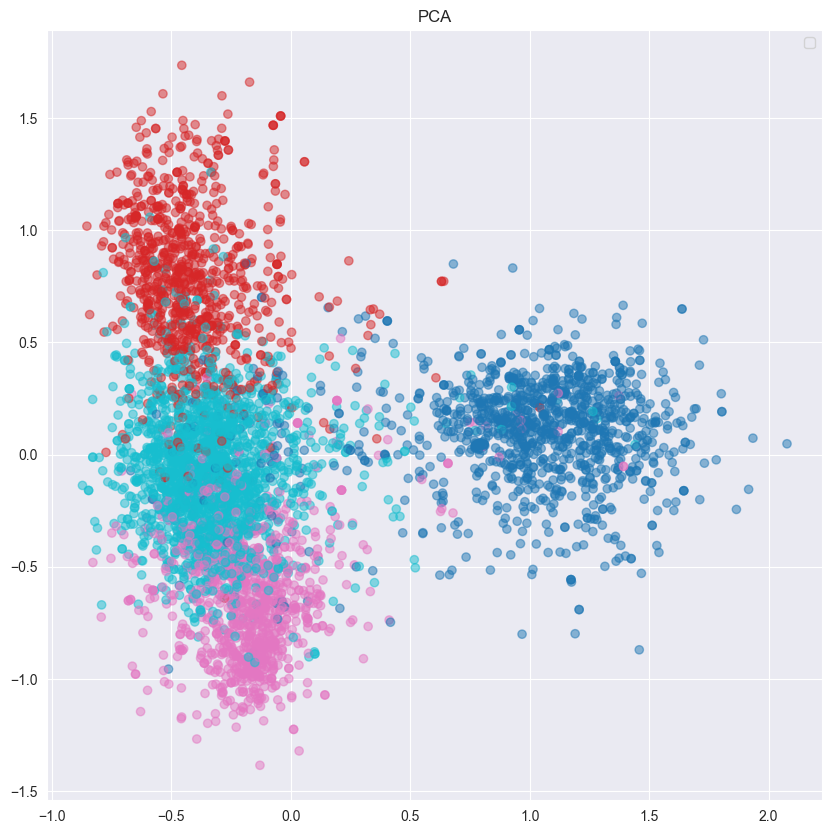

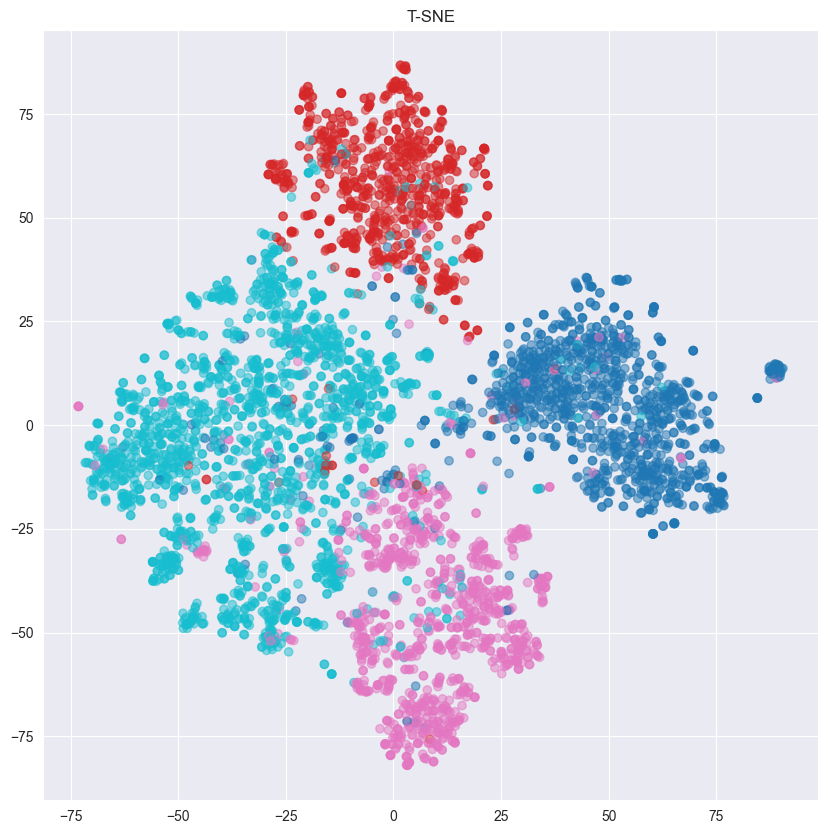

In [118]:
_, X_test, _, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model_sg_lemma = Word2Vec(X_test, window=20, min_count=2, workers=4, vector_size=300, sg=1)
wv = model_sg_lemma.wv

# Generate document vectors for each document in your corpus
size = wv.vector_size
document_vectors_test = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in X_test])

# PCA
# Reducimos la dimensionalidad a 2 para poder visualizar
pca = PCA(n_components=2)
pca.fit(document_vectors_test)
X_pca = pca.transform(document_vectors_test)

# Graficamos
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='tab10', alpha=0.5)
plt.title('PCA')
plt.legend()
plt.show()

# TSNE
# Create the model and fit it
tsne = TSNE(n_components=2, random_state=0)
data_tsne = tsne.fit_transform(document_vectors_test)

# Create the figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)

# Create the scatter
ax.scatter(data_tsne[:, 0], data_tsne[:, 1], alpha=0.5, c=y_test, cmap='tab10')
plt.title('T-SNE')

# Show the plot
plt.show()

## Clasificaciones

### Support Vector Machines

Realizamos un cross validation con 5 folds para poder obtener los mejores parámetros para nuestro modelo de SVM. Los parámetros que se probaron fueron los siguientes:

* C = [0.1, 1, 10, 100, 1000]
* kernel = ['linear', 'poly', 'rbf', 'sigmoid']
* gamma = ['scale', 'auto']

#### Fine-Tuning Model

#### Best Model

In [119]:
# SVM
from sklearn.svm import SVC
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize variables to store the models and evaluation results
models = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X):

    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]

    #Skip-gram vectorization
    model_sg_lemma = Word2Vec(X_train, window=20, min_count=2, workers=4, vector_size=300, sg=1)
    wv = model_sg_lemma.wv
    
    # Generate document vectors for each document in your corpus
    size = wv.vector_size
    document_vectors_train = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in X_train])
    document_vectors_test = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in X_test])
    
    model = SVC(kernel='rbf', C=2).fit(document_vectors_train, y_train)

    # Save the trained model
    models.append(model)

    # Evaluate the model on the validation set
    y_pred = model.predict(document_vectors_test)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))
    precision_scores.append(precision_score(y_test, y_pred, average="macro"))
    recall_scores.append(recall_score(y_test, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

* Resultados del Cross Validation

In [120]:
prom_f1 = np.mean(f1_scores)
prom_precision = np.mean(precision_scores)
prom_recall = np.mean(recall_scores)
prom_accuracy = np.mean(accuracy_scores)

print(f"F1-Score (avg): {prom_f1}")
print(f"Precision (avg): {prom_precision}")
print(f"Recall (avg): {prom_recall}")
print(f"Accuracy (avg): {prom_accuracy}")

F1-Score (avg): 0.965393780925921
Precision (avg): 0.9670360751791514
Recall (avg): 0.9638803562200096
Accuracy (avg): 0.9649372971550626


* Comparativa con LSTM (score más alto en validation : 0.9708 ) https://www.kaggle.com/code/juwonoindo/lstm-model-ecommerce-text-classification

    Para vectorizar el texto, se hace por el método de frecuencia de palabras que proovee Tokenizer de **from tensorflow.keras.preprocessing.text import Tokenizer**, sin embargo nosotros tenemos un modelo de word2vec, no obstante haremos la misma partición de los datos pero estos tendrán un diferente preprocesamiento y veremos el rendimiento de nuestros modelos

* Fast Text Vectores (test accuracy con SVC : 0.9647) : https://www.kaggle.com/code/sunilthite/e-commerce-text-classification-using-fasttext o https://www.kaggle.com/code/sevvalbicer/nlp-text-classification-with-fasttext

    En este notebook hacen una limpieza del texto a nivel de remoción de signos de puntuación y stopwords, para después pasar el texto a vectores utilzando el modelo preentrenado de FastText. Sin embargo, no utilizan ninguna semilla para separar los datos de entrenamiento y prueba, por lo que los resultados no son del todo confiables. Sin embargo para poderlo comparar lo haremos con 5 semillas distintas.

In [121]:
# Esta es la partición que utilizan
text_train, text_test, label_train, label_test = train_test_split(X, 
                                                                  y, 
                                                                  test_size=0.2, 
                                                                  random_state=45)

# Vectorización de los documentos con skip-gram
model_sg_lemma = Word2Vec(text_train, window=20, min_count=2, workers=4, vector_size=300, sg=1)
wv = model_sg_lemma.wv
size = wv.vector_size

# Generate document vectors for each document in your corpus
document_vectors_train = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in text_train])
document_vectors_test = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in text_test])

# Model
model = SVC(kernel='rbf', C=7).fit(document_vectors_train, label_train)
y_pred = model.predict(document_vectors_test)

In [122]:
f1 = f1_score(label_test, y_pred, average="macro")
precision = precision_score(label_test, y_pred, average="macro")
recall = recall_score(label_test, y_pred, average="macro")
accuracy = accuracy_score(label_test, y_pred)

print(f"F1-Score (avg): {f1}")
print(f"Precision (avg): {precision}")
print(f"Recall (avg): {recall}")
print(f"Accuracy (avg): {accuracy}")

F1-Score (avg): 0.9734884461884363
Precision (avg): 0.9743319559620289
Recall (avg): 0.9726798658339213
Accuracy (avg): 0.9733267228557263


Ahora lo hacemos para 4 semillas y poder comparar con el de fastText que no hace uso de ninguna semilla y por lo tanto su scores no son válidos.

In [123]:
seeds = [0, 42, 45, 50]

f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

for seed in seeds:
    # Esta es la partición que utilizan
    text_train, text_test, label_train, label_test = train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.2, 
                                                                    random_state=seed)

    # Vectorización de los documentos con skip-gram
    model_sg_lemma = Word2Vec(text_train, window=20, min_count=2, workers=4, vector_size=300, sg=1)
    wv = model_sg_lemma.wv
    size = wv.vector_size

    # Generate document vectors for each document in your corpus
    document_vectors_train = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in text_train])
    document_vectors_test = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in text_test])

    # Model
    model = SVC(kernel='rbf', C=7).fit(document_vectors_train, label_train)
    y_pred = model.predict(document_vectors_test)
    
    f1_scores.append(f1_score(label_test, y_pred, average="macro"))
    precision_scores.append(precision_score(label_test, y_pred, average="macro"))
    recall_scores.append(recall_score(label_test, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(label_test, y_pred))

In [124]:
prom_f1 = np.mean(f1_scores)
prom_precision = np.mean(precision_scores)
prom_recall = np.mean(recall_scores)
prom_accuracy = np.mean(accuracy_scores)

print(f"F1-Score (avg): {prom_f1}")
print(f"Precision (avg): {prom_precision}")
print(f"Recall (avg): {prom_recall}")
print(f"Accuracy (avg): {prom_accuracy}")

F1-Score (avg): 0.9727707892547434
Precision (avg): 0.9732446454283324
Recall (avg): 0.9723390421515434
Accuracy (avg): 0.9727813584531483


Notemos que el modelo de FastText con SVC tiene un score de 0.9647. Sin embargo, nosotros 4 semillas distintas obtenemos 0.9727 de accuracy. Por lo que podemos decir que nuestro modelo predictivo usando vectores de Word2Vec es mejor que el de FastText.

Por otro lado el modelo de LSTM tiene un score de 0.9708, por lo que podemos decir que nuestro modelo predictivo usando vectores de Word2Vec es mejor que el de LSTM.

### XGBoost

Nuevamente hacemos CV con 5 folds. Los parámetros que se probaron fueron los siguientes:

* objective = 'multi:softmax'
* n_estimators = [100, 500, 1000]
* early_stopping_rounds = [5, 10, 15]
* random_state = 42

#### Fine-Tuning Model

Dentro de una muestra de nuestros datos (debido a la cantidad y tiempo de ejecución), realizaremos una búsqueda de hiperparámetros utilizando la optimización de Bayes. Para ello, utilizaremos la librería de **hyperopt**.


In [125]:
# Creando una muestra de los datos para probar hiperparámetros
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.3, random_state=42, stratify=y)
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

# Vectorización de los documentos con skip-gram
model_sg_lemma = Word2Vec(X_sample_train, window=20, min_count=2, workers=4, vector_size=300, sg=1)
wv = model_sg_lemma.wv

size = wv.vector_size

# Generate document vectors for each document in your corpus
document_vectors_sample_train = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in X_sample_train])
document_vectors_sample_test = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in X_sample_test])

In [126]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from sklearn.metrics import accuracy_score, roc_auc_score
from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]], X_train: pd.DataFrame, y_train: pd.Series,
                    X_test: pd.DataFrame, y_test: pd.Series,
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.
    This function takes a dictionary of hyperparameters, training
    and test data, and an optional value for early stopping rounds,
    and returns a dictionary with the loss and model resulting from
    the tuning process. The model is trained using the training
    data and evaluated on the test data. The loss is computed as
    the negative of the accuracy score.
    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy
    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the
        tuning process. The loss is a float, and the model is an
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    
    space['early_stopping_rounds'] = early_stopping_rounds
    
    model = XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                    (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation,
              verbose=False)
    
    pred = model.predict(X_test)
    score = metric(y_test, pred)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [127]:
options = {'max_depth': hp.quniform('max_depth', 1, 15, 1), # tree
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
           'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': hp.uniform('reg_alpha', 0, 10),
           'reg_lambda': hp.uniform('reg_lambda', 1, 10),
           'gamma': hp.loguniform('gamma', -10, 10), # regularization
           'learning_rate': hp.loguniform('learning_rate', -7, 0), # boosting
           'random_state': 42
}
trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space,
                                                   document_vectors_sample_train,
                                                   y_sample_train,
                                                   document_vectors_sample_test,
                                                   y_sample_test,
                                                   early_stopping_rounds=50),
            space=options,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials,
            ) #timeout=60*5 # 5 minutos de tiempo de ejecución

100%|██████████| 10/10 [06:01<00:00, 36.13s/trial, best loss: -0.9527428949107734]


In [128]:
best

{'colsample_bytree': 0.5010133145352074,
 'gamma': 0.18752563600137176,
 'learning_rate': 0.8626223006979002,
 'max_depth': 6.0,
 'min_child_weight': 0.8668079043090229,
 'reg_alpha': 5.553382988521488,
 'reg_lambda': 5.252021720624782,
 'subsample': 0.9566763667985875}

In [130]:
long_params = {'colsample_bytree': 0.5010133145352074,
               'gamma': 0.18752563600137176,
               'learning_rate': 0.8626223006979002,
               'max_depth': 6,
               'min_child_weight': 0.8668079043090229,
               'reg_alpha': 5.553382988521488,
               'reg_lambda': 5.252021720624782,
               'subsample': 0.9566763667985875}

#### Best Model

In [131]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize variables to store the models and evaluation results
models = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X):

    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = np.array(y[train_index]), np.array(y[val_index])

    # Skip-gram
    model_sg_lemma = Word2Vec(X_train, window=20, min_count=2, workers=4, vector_size=300, sg=1)
    wv = model_sg_lemma.wv
    
    # Generate document vectors for each document in your corpus
    size = wv.vector_size
    document_vectors_train = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in X_train])
    document_vectors_test = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in X_test])
    
    model = XGBClassifier(**long_params, early_stopping_rounds=50, n_estimators=100)
    model.fit(document_vectors_train, y_train, 
              eval_set=[(document_vectors_train, y_train),(document_vectors_test, y_test)])

    # Save the trained model
    models.append(model)

    # Evaluate the model on the validation set
    y_pred = model.predict(document_vectors_test)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))
    precision_scores.append(precision_score(y_test, y_pred, average="macro"))
    recall_scores.append(recall_score(y_test, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

[0]	validation_0-mlogloss:0.57040	validation_1-mlogloss:0.58749
[1]	validation_0-mlogloss:0.37635	validation_1-mlogloss:0.40297
[2]	validation_0-mlogloss:0.28347	validation_1-mlogloss:0.31720
[3]	validation_0-mlogloss:0.22875	validation_1-mlogloss:0.26867
[4]	validation_0-mlogloss:0.19253	validation_1-mlogloss:0.23769
[5]	validation_0-mlogloss:0.16792	validation_1-mlogloss:0.21670
[6]	validation_0-mlogloss:0.14634	validation_1-mlogloss:0.19968
[7]	validation_0-mlogloss:0.12949	validation_1-mlogloss:0.18482
[8]	validation_0-mlogloss:0.11763	validation_1-mlogloss:0.17511
[9]	validation_0-mlogloss:0.10531	validation_1-mlogloss:0.16532
[10]	validation_0-mlogloss:0.09613	validation_1-mlogloss:0.15990
[11]	validation_0-mlogloss:0.08738	validation_1-mlogloss:0.15254
[12]	validation_0-mlogloss:0.07976	validation_1-mlogloss:0.14621
[13]	validation_0-mlogloss:0.07299	validation_1-mlogloss:0.14168
[14]	validation_0-mlogloss:0.06701	validation_1-mlogloss:0.13823
[15]	validation_0-mlogloss:0.06129	

In [132]:
prom_f1 = np.mean(f1_scores)
prom_precision = np.mean(precision_scores)
prom_recall = np.mean(recall_scores)
prom_accuracy = np.mean(accuracy_scores)

print(f"F1-Score (avg): {prom_f1}")
print(f"Precision (avg): {prom_precision}")
print(f"Recall (avg): {prom_recall}")
print(f"Accuracy (avg): {prom_accuracy}")

F1-Score (avg): 0.9765213889896959
Precision (avg): 0.9777426736445058
Recall (avg): 0.9753619029856395
Accuracy (avg): 0.9762612911238211


### Naive Bayes

#### Fine-Tuning Model

#### Best Model